# Проект: Классификация тональности отзывов о ресторанах

Перед нами стоит задача классификации тональности текста для автоматизации анализа обратной связи в случаях, когда пользователи не ставят числовую оценку.

## Задачи проекта:

1. Предобработать данные.
2. Обучить несколько моделей для задачи классификации и сравнить их между собой:
    1. Наивный Байес
    1. TF-IDF
    1. Сверточную модель

In [1]:
!pip install multiprocess wandb -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.1/296.1 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.0 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import nltk
import pandas as pd
import re
import torch
import torch.nn.functional as F
import wandb

from collections import Counter
from gensim.corpora.dictionary import Dictionary
from multiprocess import Pool
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

from tqdm.auto import tqdm

In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Загрузка данных

Мы будем использовать датасет Yelp. Он содержит около 450 тысяч коротких негативных и позитивных отзывов о ресторанах.

In [3]:
# !gdown 1bR4D-uoUsYYneAZG0TGnoiM-Pb0DKj4m
# !gdown 1ZTQjKEdzMZ23AcAJLBypuK2H_MXKDoSr

In [4]:
train_data = pd.read_csv('yelp_train.csv')
test_data = pd.read_csv('yelp_test.csv')

texts_train = train_data.text
labels_train = train_data.label
texts_test = test_data.text
labels_test = test_data.label

In [5]:
train_data.shape, test_data.shape

((443259, 2), (1000, 2))

In [6]:
texts_train[:5]

0    the service and food is always consistent and ...
1                                      honest people .
2                          it 's all very impressive .
3                              its decor is horrible .
4    definitely will go back to try some of their o...
Name: text, dtype: object

Посмотрим на распределение классов:

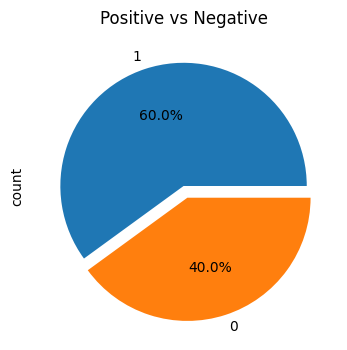

In [7]:
labels_train.value_counts().plot(kind='pie', explode=[0, 0.1], figsize=(4, 4), autopct='%1.1f%%')
plt.title("Positive vs Negative")
plt.show()

Для оценки качества можем использовать обычную точность (accuracy), так как классы достаточно сбалансированы.

## Предобработка данных

Выполним следующую предобработку тренировочных и тестовых данных:
- приведем к нижнему регистру,
- удалим пунктуацию,
- лемматизируем.

В этом проекте не будем удалять стоп-слова, так как они могут быть важны для классификации тональности.

In [5]:
def clean_text(text):
    text = text.lower()  # Приведение к нижнему регистру
    text = ''.join(c for c in text if c.isalnum() or c.isspace())  # Удаление знаков препинания

    lemmatizer = WordNetLemmatizer() # Лемматизация
    lemmatized = [lemmatizer.lemmatize(word) for word in text.split()]

    return lemmatized

with Pool(4) as pool:
    texts_train = pool.map(clean_text, tqdm(texts_train))
    texts_test = pool.map(clean_text, tqdm(texts_test))

print(texts_train[:5])

with open("clean_text_train.txt", "w") as f:
    for text in texts_train:
        f.write(" ".join(text))
        f.write("\n")

  0%|          | 0/443259 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[['the', 'service', 'and', 'food', 'is', 'always', 'consistent', 'and', 'great'], ['honest', 'people'], ['it', 's', 'all', 'very', 'impressive'], ['it', 'decor', 'is', 'horrible'], ['definitely', 'will', 'go', 'back', 'to', 'try', 'some', 'of', 'their', 'other', 'option']]


## Метрика

Как уже было сказано, для оценки качества будем считать точность.

## Наивный Байес

Обучим Наивный Байес на Bag of Words представлениях текстов. В качестве модели возьмем `MultinomialNB`.

In [12]:
def train_nb_model(texts_train, labels_train):
    bow_vectorizer = CountVectorizer(
        min_df=4,
        max_df=0.95,
        tokenizer=lambda text: text,
        preprocessor=lambda text: text
    )
    X_train = bow_vectorizer.fit_transform(texts_train)
    model = MultinomialNB()
    model.fit(X_train, labels_train)
    return model, bow_vectorizer


def predict_nb_model(model, bow, texts_test):
    X_test = bow.transform(texts_test)
    return model.predict(X_test)

model, bow = train_nb_model(texts_train, labels_train)

train_acc = accuracy_score(labels_train, predict_nb_model(model, bow, texts_train))
test_acc = accuracy_score(labels_test, predict_nb_model(model, bow, texts_test))
train_acc, test_acc

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(0.9365675598239404, 0.926)

## TF-IDF + Логистическая регрессия

Наивный Байес редко работает хорошо, так как он очень чувствителен к редким словам. Гораздо более распространенный и рабочий подход - любой классификатор (логистическая регрессия, SVM, случайный лес, градиентный бустинг) поверх TF-IDF признаков.

Закодируем тексты с помощью TF-IDF и обучим на этом логистическую регрессию.

In [13]:
def train_lr_model(texts_train, labels_train):
    tfidf_vectorizer = TfidfVectorizer(
        min_df=4,
        max_df=0.95,
        tokenizer=lambda text: text,
        preprocessor=lambda text: text
    )
    tfidf_vectorizer.fit(texts_train)
    X_train = tfidf_vectorizer.transform(texts_train)
    model = LogisticRegression()
    model.fit(X_train, labels_train)
    return model, tfidf_vectorizer


def predict_lr_model(model, tfidf, texts_test):
    X_test = tfidf.transform(texts_test)
    return model.predict(X_test)


model, tfidf = train_lr_model(texts_train, labels_train)

train_acc = accuracy_score(labels_train, predict_lr_model(model, tfidf, texts_train))
test_acc = accuracy_score(labels_test, predict_lr_model(model, tfidf, texts_test))
train_acc, test_acc

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.9674524375139592, 0.96)

## TF-IDF и n-граммы

На данный момент мы вообще не учитываем связи между словами, хотя для нашей задачи они точно важны. Например "хорошо" в сочетании с "не" имеет полностью противоположный смысл, что напрямую влияет на класс. Хотелось бы дать возможность модели получать эту информацию напрямую. Самый популярный на практике способ это сделать - добавить в модель n-граммы слов.

In [14]:
def train_lr_model(texts_train, labels_train):
    tfidf_vectorizer = TfidfVectorizer(
        min_df=4,
        max_df=0.95,
        tokenizer=lambda text: text,
        preprocessor=lambda text: text,
        ngram_range=(1, 3)
    )
    tfidf_vectorizer.fit(texts_train)
    X_train = tfidf_vectorizer.transform(texts_train)
    model = LogisticRegression()
    model.fit(X_train, labels_train)
    return model, tfidf_vectorizer


def predict_lr_model(model, tfidf, texts_test):
    X_test = tfidf.transform(texts_test)
    return model.predict(X_test)


model, tfidf = train_lr_model(texts_train, labels_train)

train_acc = accuracy_score(labels_train, predict_lr_model(model, tfidf, texts_train))
test_acc = accuracy_score(labels_test, predict_lr_model(model, tfidf, texts_test))
train_acc, test_acc

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(0.9785542989538848, 0.968)

Итак, TF-IDF с Logistic Regression и n-граммами - наш бейзлайн, который выдает accuracy на тесте = 0.97

## Сверточные нейронные сети

Попробуем перебить бейзлайн сверточной сетью, которая извлечет контекстную информацию, влияющую на тональность.

### Подготовка датасета

Для обучения нейронных сетей нам нужно немного переделать датасет. Во-первых, удалим все редкие слова. При обучении TF-IDF для таких слов автоматически ставился низкий вес. Сверточная сеть же учитывает все слова с одним вестом и редкие слова выучивает гораздо хуже, из-за чего качество может упасть.

Удалим из тренировочного и тестового корпусов все слова, которые встречаются меньше, чем в 15 текстах в тренировочной выборке:

In [6]:
# Считаем частоту слов в тренировочном корпусе
word_counts = Counter(y for x in texts_train for y in set(x))

# Определяем редкие слова, которые встречаются меньше 15 раз
rare_words = {word for word, count in word_counts.items() if count < 15}

# Удаляем редкие слова в тренировочном и тестовом корпусах
texts_train = [[word for word in text if word not in rare_words] for text in texts_train]
texts_test = [[word for word in text if word not in rare_words] for text in texts_test]

In [7]:
print(texts_train[:5])

[['the', 'service', 'and', 'food', 'is', 'always', 'consistent', 'and', 'great'], ['honest', 'people'], ['it', 's', 'all', 'very', 'impressive'], ['it', 'decor', 'is', 'horrible'], ['definitely', 'will', 'go', 'back', 'to', 'try', 'some', 'of', 'their', 'other', 'option']]


Нейронная сеть получает на вход индексы слов. Соответственно, нам надо превратить слова в индексы.

In [8]:
dictionary = Dictionary(texts_train)
dictionary.add_documents([['PAD', 'UNK']])
len(dictionary)

5947

In [9]:
list(dictionary.token2id.items())[:5]

[('always', 0), ('and', 1), ('consistent', 2), ('food', 3), ('great', 4)]

Соберем датасет из пар (текст, класс), чтобы можно было подать его в `DataLoader`.

In [10]:
train_dataset = list(zip(texts_train, labels_train))
test_dataset = list(zip(texts_test, labels_test))

In [11]:
# Функция для обработки каждого батча
# Добавляем паддинги и превращаем все в тензоры
def collate_fn(batch):
    texts, labels = zip(*batch)
    pad_token_id = dictionary.token2id['PAD']
    unk_token_id = dictionary.token2id['UNK']
    input_ids = [torch.tensor(dictionary.doc2idx(text, unknown_word_index=unk_token_id)) for text in texts]
    return (
        pad_sequence(input_ids, padding_value=pad_token_id).permute(1, 0).to(torch.long),
        torch.tensor(labels)
    )

Наконец, получаем `DataLoader`, из которого мы будем доставать данные.

In [12]:
train_loader = DataLoader(train_dataset, collate_fn=collate_fn, shuffle=True, batch_size=128)
test_loader = DataLoader(test_dataset, collate_fn=collate_fn, shuffle=False, batch_size=32)

Напишим простую сверточную сеть:

In [25]:
class CNN(nn.Module):
    def __init__(self, vocab_size, hid_dim, kernel_sizes=[3, 4, 5]):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, hid_dim)

        self.conv = nn.ModuleList([
            nn.Conv1d(in_channels=hid_dim, out_channels=hid_dim, kernel_size=k) for k in kernel_sizes
        ])
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(len(kernel_sizes) * hid_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = [self.relu(conv(x)) for conv in self.conv]
        x = [F.max_pool1d(c, c.size(-1)).squeeze(dim=-1) for c in x]
        x = torch.cat(x, dim=1)
        x = self.fc(self.dropout(x))
        return x

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
model = CNN(vocab_size=len(dictionary), hid_dim=100).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

n_params = sum(torch.numel(p) for p in model.parameters())
n_emb_params = sum(torch.numel(p) for p in model.embedding.parameters())
print(f"Число параметров без эмбеддингов: {n_params - n_emb_params}")

Число параметров без эмбеддингов: 120601


Обучим полученную модель на обработанных данных.

In [28]:
def train(model, dataloader, optimizer):
    """
    Обучает модель (model) на всем наборе данных (dataloader).
    """
    model.train()
    criterion = nn.BCEWithLogitsLoss()

    for i, (tokens, labels) in enumerate(dataloader):
        tokens = tokens.to(device)
        labels = labels.to(device).float()

        logits = model(tokens).squeeze(1)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_accuracy = ((torch.sigmoid(logits) > 0.5) == labels).float().mean().item()

        # логируем значения ошибки и точности
        wandb.log({
            "train_loss": loss.item(),
            "train_accuracy": train_accuracy
        })


@torch.inference_mode()
def evaluate(model, dataloader):
    """
    Тестирует модель (model) на всем наборе данных (dataloader).
    """
    model.eval()
    criterion = nn.BCEWithLogitsLoss()

    correct = []
    losses = []
    for i, (tokens, labels) in enumerate(dataloader):
        tokens = tokens.to(device)
        labels = labels.to(device).float()

        logits = model(tokens).squeeze(1)
        loss = criterion(logits, labels)

        correct.extend(((torch.sigmoid(logits) > 0.5) == labels).float().cpu().numpy())
        losses.append(loss.item())

    mean_loss = np.mean(losses)
    accuracy = np.mean(correct)

    # логируем тестовые значения ошибки и точности
    wandb.log({
        "test_loss": mean_loss,
        "test_accuracy": accuracy
    })

    return accuracy, mean_loss

In [29]:
wandb.login()
wandb.init(project='Yelp', name='cnn_simple_lr=1e-4')

for epoch in range(20):
    train(model, train_loader, optimizer)
    test_acc, test_loss = evaluate(model, test_loader)
    print(f"Epoch {epoch+1}, Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1, Test Accuracy: 0.9170, Test Loss: 0.2143
Epoch 2, Test Accuracy: 0.9360, Test Loss: 0.1622
Epoch 3, Test Accuracy: 0.9410, Test Loss: 0.1369
Epoch 4, Test Accuracy: 0.9470, Test Loss: 0.1179
Epoch 5, Test Accuracy: 0.9550, Test Loss: 0.1019
Epoch 6, Test Accuracy: 0.9570, Test Loss: 0.0980
Epoch 7, Test Accuracy: 0.9550, Test Loss: 0.0960
Epoch 8, Test Accuracy: 0.9620, Test Loss: 0.0896
Epoch 9, Test Accuracy: 0.9600, Test Loss: 0.0880
Epoch 10, Test Accuracy: 0.9630, Test Loss: 0.0849
Epoch 11, Test Accuracy: 0.9630, Test Loss: 0.0824
Epoch 12, Test Accuracy: 0.9650, Test Loss: 0.0832
Epoch 13, Test Accuracy: 0.9670, Test Loss: 0.0789
Epoch 14, Test Accuracy: 0.9690, Test Loss: 0.0784
Epoch 15, Test Accuracy: 0.9660, Test Loss: 0.0803
Epoch 16, Test Accuracy: 0.9660, Test Loss: 0.0770
Epoch 17, Test Accuracy: 0.9670, Test Loss: 0.0778
Epoch 18, Test Accuracy: 0.9660, Test Loss: 0.0777
Epoch 19, Test Accuracy: 0.9680, Test Loss: 0.0755
Epoch 20, Test Accuracy: 0.9670, Test Lo

При текущей архитектуре и конфигурации сети (dropout=0.1, lr=1e-4) получили accuracy = 0.967 на 20 эпохе.

Изменим пока только dropout до 0.3 и проверим поможет ли это:

In [31]:
class CNN(nn.Module):
    def __init__(self, vocab_size, hid_dim, kernel_sizes=[3, 4, 5]):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, hid_dim)

        self.conv = nn.ModuleList([
            nn.Conv1d(in_channels=hid_dim, out_channels=hid_dim, kernel_size=k) for k in kernel_sizes
        ])
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(len(kernel_sizes) * hid_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = [self.relu(conv(x)) for conv in self.conv]
        x = [F.max_pool1d(c, c.size(-1)).squeeze(dim=-1) for c in x]
        x = torch.cat(x, dim=1)
        x = self.fc(self.dropout(x))
        return x

In [32]:
model = CNN(vocab_size=len(dictionary), hid_dim=100).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
wandb.init(project='Yelp', name='cnn_simple_lr=1e-4_dropout=0.3')

for epoch in range(20):
    train(model, train_loader, optimizer)
    test_acc, test_loss = evaluate(model, test_loader)
    print(f"Epoch {epoch+1}, Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

wandb.finish()

test_accuracy,▁▄▄▅▆▆▆▇▇▇▇▇████████
test_loss,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▆▅▇▆▇▆█▇▆▆▇▇▇▆▇▇█▇█▇▇▆▇▇█▆██▇▆▇█▇▇███▇
train_loss,█▅▄▄▂▃▂▃▂▃▃▃▃▂▂▂▃▂▂▃▂▂▂▃▂▃▁▂▁▂▁▃▂▁▂▂▁▁▁▁
test_accuracy,0.967
test_loss,0.07623
train_accuracy,0.98374
train_loss,0.04567


Epoch 1, Test Accuracy: 0.9080, Test Loss: 0.2396
Epoch 2, Test Accuracy: 0.9300, Test Loss: 0.1794


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 3, Test Accuracy: 0.9350, Test Loss: 0.1583
Epoch 4, Test Accuracy: 0.9430, Test Loss: 0.1298
Epoch 5, Test Accuracy: 0.9500, Test Loss: 0.1142
Epoch 6, Test Accuracy: 0.9580, Test Loss: 0.1046
Epoch 7, Test Accuracy: 0.9600, Test Loss: 0.0945
Epoch 8, Test Accuracy: 0.9610, Test Loss: 0.0920
Epoch 9, Test Accuracy: 0.9600, Test Loss: 0.0865
Epoch 10, Test Accuracy: 0.9610, Test Loss: 0.0875
Epoch 11, Test Accuracy: 0.9650, Test Loss: 0.0856
Epoch 12, Test Accuracy: 0.9670, Test Loss: 0.0826
Epoch 13, Test Accuracy: 0.9670, Test Loss: 0.0806
Epoch 14, Test Accuracy: 0.9620, Test Loss: 0.0812
Epoch 15, Test Accuracy: 0.9640, Test Loss: 0.0847
Epoch 16, Test Accuracy: 0.9630, Test Loss: 0.0839
Epoch 17, Test Accuracy: 0.9620, Test Loss: 0.0889
Epoch 18, Test Accuracy: 0.9660, Test Loss: 0.0833
Epoch 19, Test Accuracy: 0.9700, Test Loss: 0.0770
Epoch 20, Test Accuracy: 0.9680, Test Loss: 0.0760


test_accuracy,▁▃▄▅▆▇▇▇▇▇▇██▇▇▇▇███
test_loss,█▅▅▃▃▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁
train_accuracy,▁▂▅▆▄▅▆▅▆▅▅▅▅▆▆▆▇▆█▇▆▆▆▇▆▇█▆▇█▆█▇▇█▆█▆██
train_loss,█▆▄▄▅▃▂▃▂▃▂▂▃▃▂▂▂▂▁▂▂▂▂▂▃▁▁▂▂▁▂▁▂▂▁▂▁▃▁▁
test_accuracy,0.968
test_loss,0.07595
train_accuracy,0.97561
train_loss,0.05648


При dropout=0.3 и lr=1e-4 получили accuracy = 0.968 на 20 эпохе. Незначительно лучше.

Попробуем изменить learning rate на 5e-4:

In [33]:
model = CNN(vocab_size=len(dictionary), hid_dim=100).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)
wandb.init(project='Yelp', name='cnn_simple_lr=5e-4')

for epoch in range(20):
    train(model, train_loader, optimizer)
    test_acc, test_loss = evaluate(model, test_loader)
    print(f"Epoch {epoch+1}, Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

wandb.finish()

Epoch 1, Test Accuracy: 0.9570, Test Loss: 0.1129
Epoch 2, Test Accuracy: 0.9660, Test Loss: 0.0963
Epoch 3, Test Accuracy: 0.9610, Test Loss: 0.1017
Epoch 4, Test Accuracy: 0.9610, Test Loss: 0.0901
Epoch 5, Test Accuracy: 0.9630, Test Loss: 0.0891
Epoch 6, Test Accuracy: 0.9620, Test Loss: 0.0870
Epoch 7, Test Accuracy: 0.9650, Test Loss: 0.0887
Epoch 8, Test Accuracy: 0.9640, Test Loss: 0.0840
Epoch 9, Test Accuracy: 0.9650, Test Loss: 0.0808
Epoch 10, Test Accuracy: 0.9660, Test Loss: 0.0851
Epoch 11, Test Accuracy: 0.9680, Test Loss: 0.0875
Epoch 12, Test Accuracy: 0.9680, Test Loss: 0.0822
Epoch 13, Test Accuracy: 0.9680, Test Loss: 0.0839
Epoch 14, Test Accuracy: 0.9710, Test Loss: 0.0826
Epoch 15, Test Accuracy: 0.9710, Test Loss: 0.0757
Epoch 16, Test Accuracy: 0.9710, Test Loss: 0.0781
Epoch 17, Test Accuracy: 0.9680, Test Loss: 0.0805
Epoch 18, Test Accuracy: 0.9680, Test Loss: 0.0795
Epoch 19, Test Accuracy: 0.9720, Test Loss: 0.0794
Epoch 20, Test Accuracy: 0.9700, Test Lo

test_accuracy,▁▅▃▃▄▃▅▄▅▅▆▆▆███▆▆█▇
test_loss,█▅▆▄▄▃▄▃▂▃▃▃▃▃▁▂▂▂▂▁
train_accuracy,▁▃▇█▆▅█▇▇▄▆▆▅▆▇▃▇▄▅▇█▇▇▇▆█▇▆▇▇▆▇▇▇▇▇▄▇▆▇
train_loss,█▅▄▂▃▄▂▂▁▄▃▂▅▂▃▅▂▄▂▂▂▁▃▃▂▁▂▃▂▂▂▂▂▃▂▂▃▂▃▂
test_accuracy,0.97
test_loss,0.07349
train_accuracy,0.95122
train_loss,0.20162


При dropout=0.3 и lr=5e-4 получили accuracy = 0.97 на 20 эпохе, что лучше предыдущих попыток, но незначительно.

Сверточная модель хорошо улавливает контекстную информацию для каждого слова. Однако ее проблема заключается в аггрегировании выхода сверток в один вектор. При суммировании важная информация смешивается с бесполезной, почти то же самое происходит и с max-pooling.  

Для решения этой проблемы добавим подобие механизма внимания.

In [46]:
class AttentionCNN(CNN):
    def __init__(self, vocab_size, hid_dim, kernel_sizes=[3, 4, 5]):
        super().__init__(vocab_size, hid_dim, kernel_sizes)

        self.attention = nn.ModuleList([
            nn.Linear(hid_dim, 1) for _ in kernel_sizes
        ])

        self.dropout = nn.Dropout(0.1)  # Изменено значение dropout c 0.3 на 0.1


    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        conv_outs = [self.relu(conv(x)) for conv in self.conv]

        # внимание
        attention_weights = [torch.softmax(self.attention[i](conv_out.permute(0, 2, 1)), dim=1) for i, conv_out in enumerate(conv_outs)]
        attention_outs = [torch.sum(conv_out * attn_w.permute(0, 2, 1), dim=2) for conv_out, attn_w in zip(conv_outs, attention_weights)]

        x = torch.cat(attention_outs, dim=1)
        x = self.fc(self.dropout(x))
        return x

In [47]:
model = AttentionCNN(vocab_size=len(dictionary), hid_dim=100).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)
wandb.init(project='Yelp', name='AttentionСNN_lr=5e-4_dropout=0.1')

for epoch in range(20):
    train(model, train_loader, optimizer)
    test_acc, test_loss = evaluate(model, test_loader)
    print(f"Epoch {epoch+1}, Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

wandb.finish()

Epoch 1, Test Accuracy: 0.9560, Test Loss: 0.1129
Epoch 2, Test Accuracy: 0.9650, Test Loss: 0.0946
Epoch 3, Test Accuracy: 0.9680, Test Loss: 0.0877
Epoch 4, Test Accuracy: 0.9670, Test Loss: 0.0892
Epoch 5, Test Accuracy: 0.9690, Test Loss: 0.0842
Epoch 6, Test Accuracy: 0.9690, Test Loss: 0.0862
Epoch 7, Test Accuracy: 0.9720, Test Loss: 0.0878
Epoch 8, Test Accuracy: 0.9710, Test Loss: 0.0829
Epoch 9, Test Accuracy: 0.9660, Test Loss: 0.0864
Epoch 10, Test Accuracy: 0.9680, Test Loss: 0.0769
Epoch 11, Test Accuracy: 0.9700, Test Loss: 0.0777
Epoch 12, Test Accuracy: 0.9730, Test Loss: 0.0849
Epoch 13, Test Accuracy: 0.9690, Test Loss: 0.0814
Epoch 14, Test Accuracy: 0.9660, Test Loss: 0.0877
Epoch 15, Test Accuracy: 0.9730, Test Loss: 0.0808
Epoch 16, Test Accuracy: 0.9680, Test Loss: 0.0770
Epoch 17, Test Accuracy: 0.9690, Test Loss: 0.0835
Epoch 18, Test Accuracy: 0.9760, Test Loss: 0.0728
Epoch 19, Test Accuracy: 0.9680, Test Loss: 0.0784
Epoch 20, Test Accuracy: 0.9720, Test Lo

test_accuracy,▁▄▅▅▆▆▇▆▅▅▆▇▆▅▇▅▆█▅▇
test_loss,█▅▄▄▃▃▄▃▃▂▂▃▂▄▂▂▃▁▂▂
train_accuracy,▁▄▆███▅█▆▅▆▄▇▇▆▆▇▇▇▇▆▇▇▆▆▆▇▇█▇█▆███▆▆▇▇▆
train_loss,█▅▃▃▁▂▄▂▂▄▃▅▂▂▃▄▂▂▂▂▅▂▂▃▃▄▂▃▂▃▁▂▁▁▁▂▄▃▃▃
test_accuracy,0.972
test_loss,0.07933
train_accuracy,0.95935
train_loss,0.09902


При dropout=0.1 и lr=5e-4 получили accuracy = 0.972 на 20 эпохе, что немного лучше предыдущих попыток.

In [52]:
model = AttentionCNN(vocab_size=len(dictionary), hid_dim=100).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
wandb.init(project='Yelp', name='AttentionСNN_lr=1e-3_dropout=0.1')

for epoch in range(20):
    train(model, train_loader, optimizer)
    test_acc, test_loss = evaluate(model, test_loader)
    print(f"Epoch {epoch+1}, Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

wandb.finish()

Epoch 1, Test Accuracy: 0.9610, Test Loss: 0.1041
Epoch 2, Test Accuracy: 0.9610, Test Loss: 0.1047
Epoch 3, Test Accuracy: 0.9670, Test Loss: 0.0929
Epoch 4, Test Accuracy: 0.9620, Test Loss: 0.0879
Epoch 5, Test Accuracy: 0.9680, Test Loss: 0.0892
Epoch 6, Test Accuracy: 0.9660, Test Loss: 0.0945
Epoch 7, Test Accuracy: 0.9630, Test Loss: 0.0927
Epoch 8, Test Accuracy: 0.9670, Test Loss: 0.0895
Epoch 9, Test Accuracy: 0.9670, Test Loss: 0.0935
Epoch 10, Test Accuracy: 0.9690, Test Loss: 0.0891
Epoch 11, Test Accuracy: 0.9650, Test Loss: 0.0938
Epoch 12, Test Accuracy: 0.9640, Test Loss: 0.0861
Epoch 13, Test Accuracy: 0.9640, Test Loss: 0.0925
Epoch 14, Test Accuracy: 0.9730, Test Loss: 0.0836
Epoch 15, Test Accuracy: 0.9690, Test Loss: 0.0885
Epoch 16, Test Accuracy: 0.9720, Test Loss: 0.0866
Epoch 17, Test Accuracy: 0.9760, Test Loss: 0.0789
Epoch 18, Test Accuracy: 0.9650, Test Loss: 0.0855
Epoch 19, Test Accuracy: 0.9720, Test Loss: 0.0868
Epoch 20, Test Accuracy: 0.9740, Test Lo

test_accuracy,▁▁▄▁▄▃▂▄▄▅▃▂▂▇▅▆█▃▆▇
test_loss,██▅▃▄▅▅▄▅▄▅▃▅▂▄▃▁▃▃▂
train_accuracy,▁▃▅▇▆▇▆▆▇▇▅▆▆▇█▂▅▇▇▆▆▆▆▇▆█▆▆▇▅▇▆▆▇▇█▇▅▆█
train_loss,█▆▅▃▃▂▄▃▃▂▅▃▃▂▁▇▄▃▂▃▃▃▂▂▃▁▃▂▂▅▂▂▃▃▂▁▂▄▃▁
test_accuracy,0.974
test_loss,0.08393
train_accuracy,0.99187
train_loss,0.01756


При добавлении механизма внимания, dropout=0.1 и lr=1e-4 получили accuracy = 0.974 на 20 эпохе, что лучше всех предыдущих попыток.

## Вывод

В ходе проекта была успешно решена задача классификации тональности отзывов о ресторанах. Предобработка данных и использование различных моделей, таких как Наивный Байес, логистическая регрессия с TF-IDF, CNN и AttentionCNN, позволили достичь высокой точности классификации. Лучшая модель, AttentionCNN, достигла точности 0.974, что является отличным результатом для данной задачи. Этот проект демонстрирует эффективность применения механизмов внимания и сверточных нейронных сетей для анализа текстовых данных.